In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

678 genes excluded.


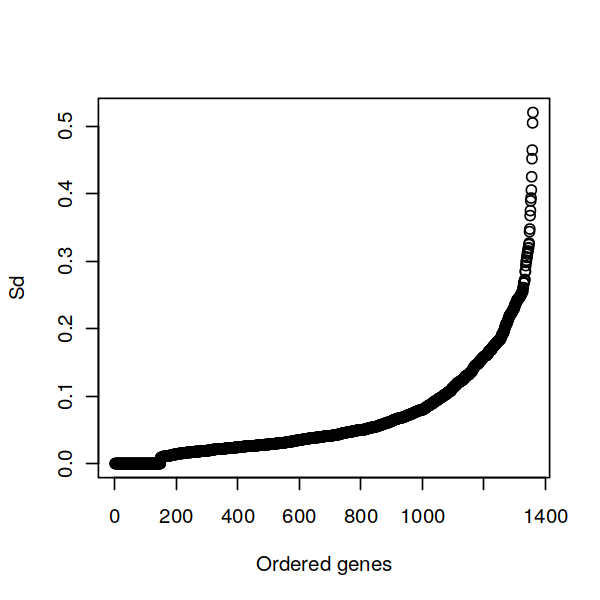

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-FL-aLP1_5to2-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

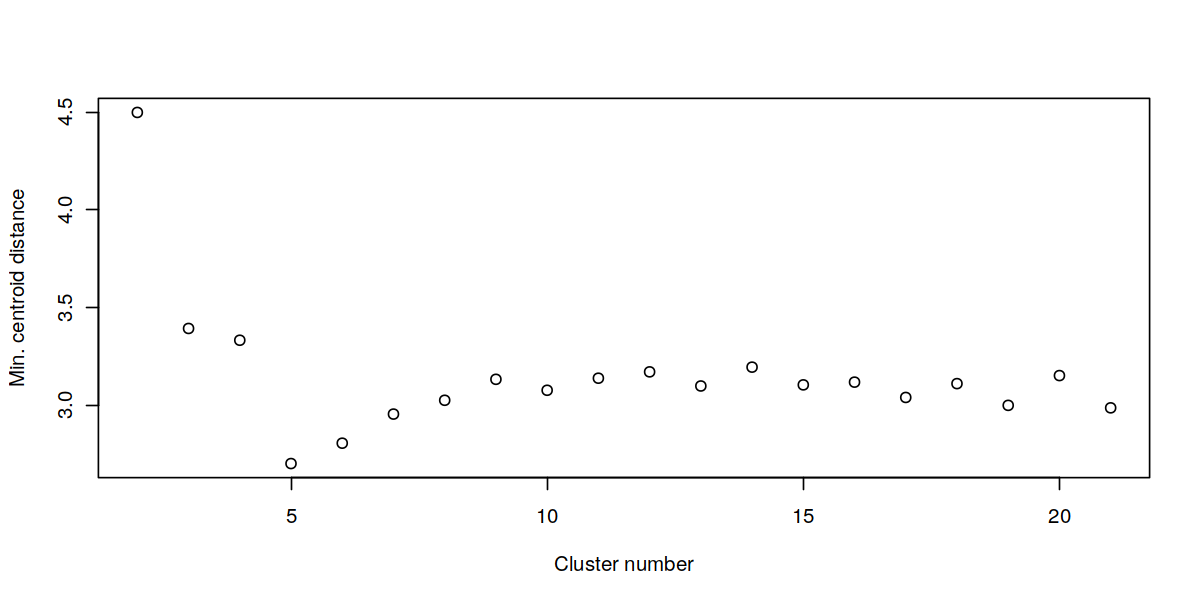

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


Warning message:
“Ignoring unknown aesthetics: order”


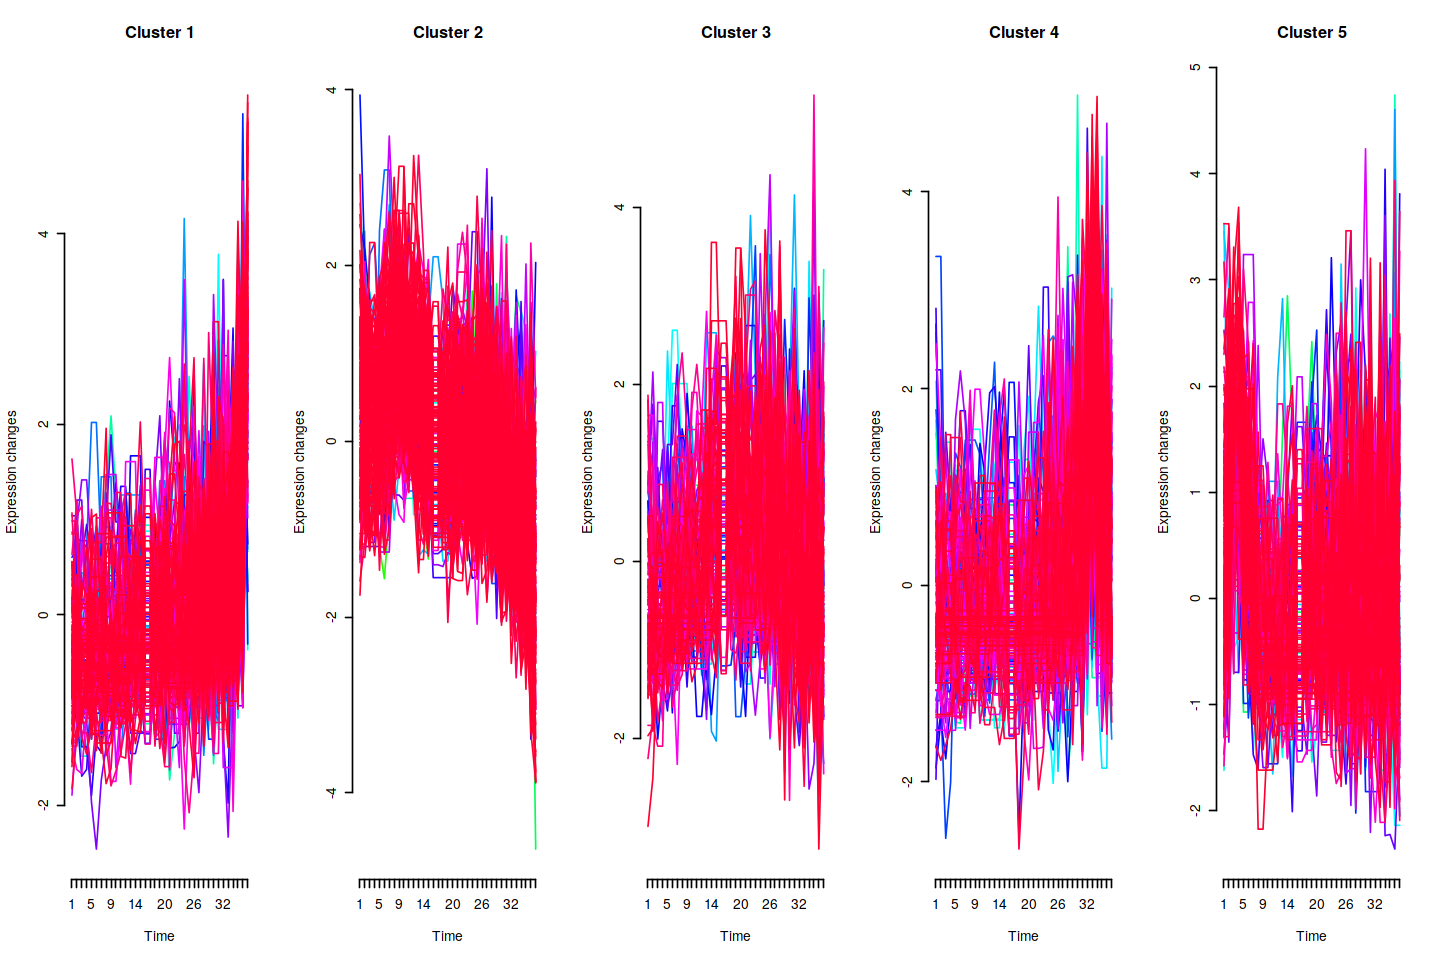

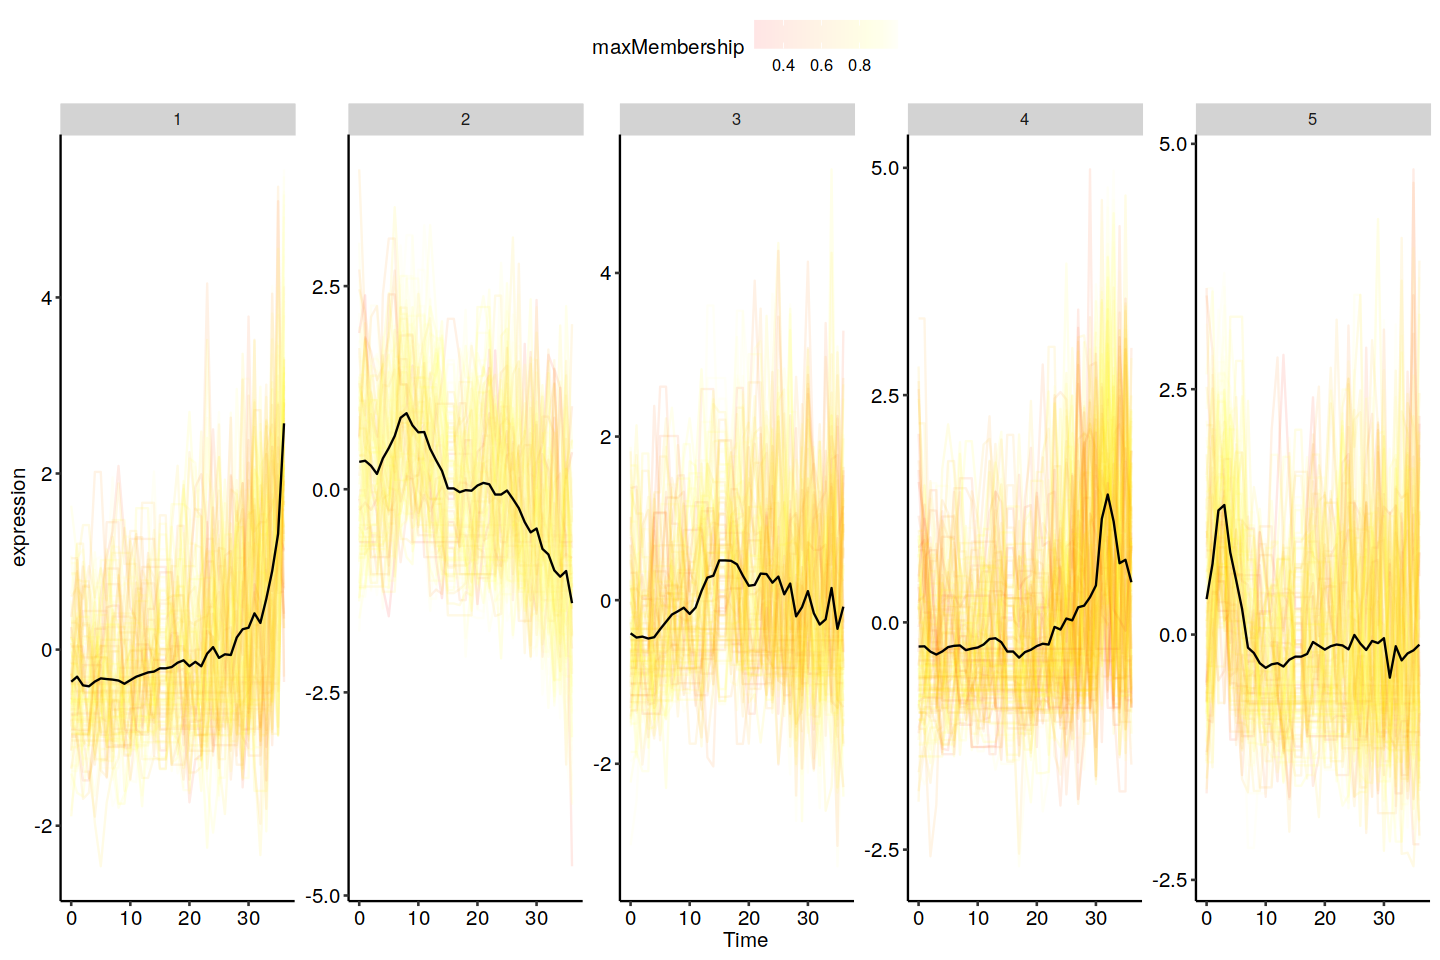

In [7]:
# 3. do clustering and show
c <- 5 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(1,5), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=1,ncol=5)

In [8]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 136 150 118 143 134

In [9]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [10]:
res1 <- path.enrichment.analysis(1)
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“0.83% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“3.6% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.1% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.17% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“7.63% of input gene I

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


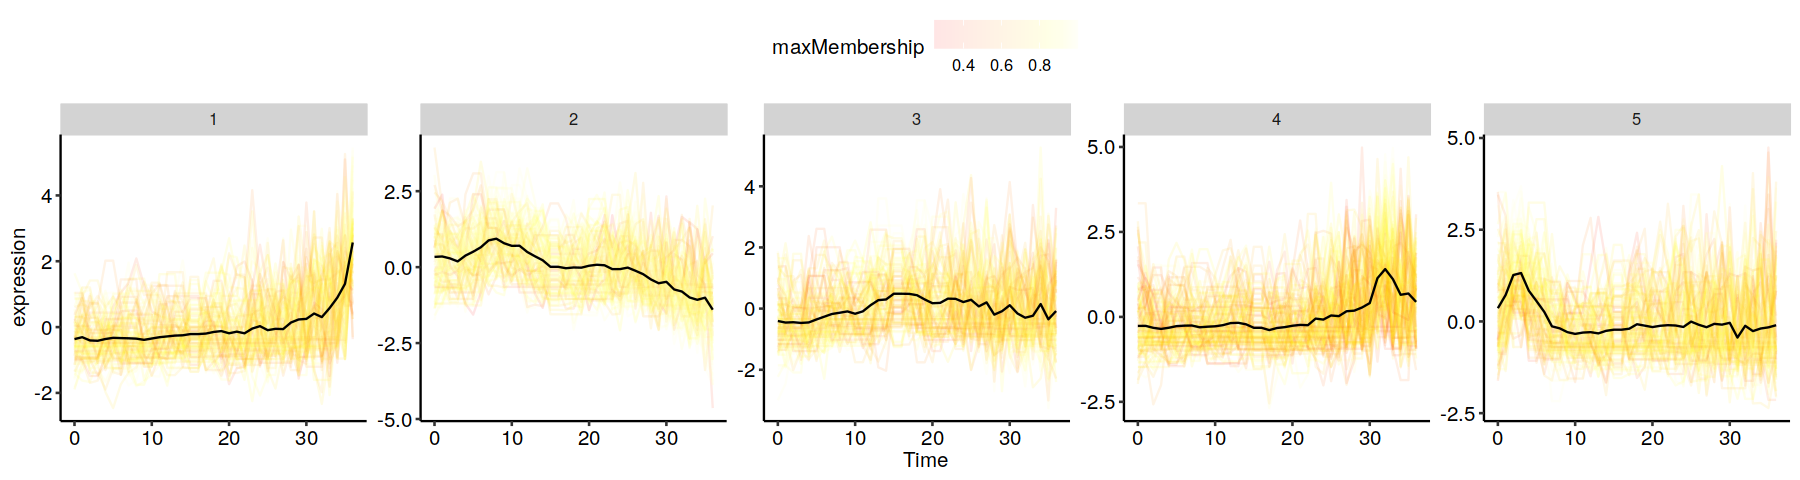

In [11]:
o(3*5, 4*1)
mFuzz.ggplot(eset, cl, centre = T, nrow=1,ncol=5)

## C1

[1] "Genes:"
Pirb Ddit4l Cd7 Cd74 Shisa5 Calm4 Ptms Tyrobp Wfdc18 Zfp36l1 Sema3d 6330403K07Rik Napsa Slc46a3 Ctsa Necab2 Wfdc17 Clec4a2 Vsir Evl Cd9 Klrd1 Ly86 Inpp5f Psap Eya2 Cd200r1 Snai3 Ifi35 Ppp1r15a H2-DMb2 Hsd11b1 4930481A15Rik Tspan13 Nucb2 H2-T23 Gsn Fam49a Sirpa Serp1 Mndal Pld4 Basp1 Ifi203 Ctss Tapbp Phf11c Ppp3ca Tcf4 Id2 Yipf2 Anxa6 Jund Selenop Il18 Fzr1 Rnase6 Mxd4 Tmsb15b1 Unc93b1 Lgals3 Ighm Hoxa9 Fam117b Nfam1 Lsp1 H2-DMa Cyba Cd52 Alox5ap Ypel3 Tnfaip8l2 Gm2a Gm5086 Cln8 Ltb Il21r Socs3 Trbc2 Tnni2 Ccl3 Tpd52 Nmrk1 Acadm Rrad Arid3a Tspan32 Rtp4 Ckb Paip2b Plp2 Cyth4 Stk17b Il1r2 4931406C07Rik Lmo2 Evi5 Cd69 Cst3 Mfap2 Ighv1-77 Abhd6 Fth1 Capsl Grina Dusp22 Dennd1c Vasp Junb Maged1 Lgals9 Tnfrsf13b Tifab Ppfia4 Zcchc18 Btg1 Dusp1 Pltp Paqr7 Tubb2a Tmem119NULL
[1] "TFs:"
Cd7 Zfp36l1 Eya2 Snai3 Tcf4 Id2 Jund Mxd4 Hoxa9 Arid3a Lmo2 JunbNULL


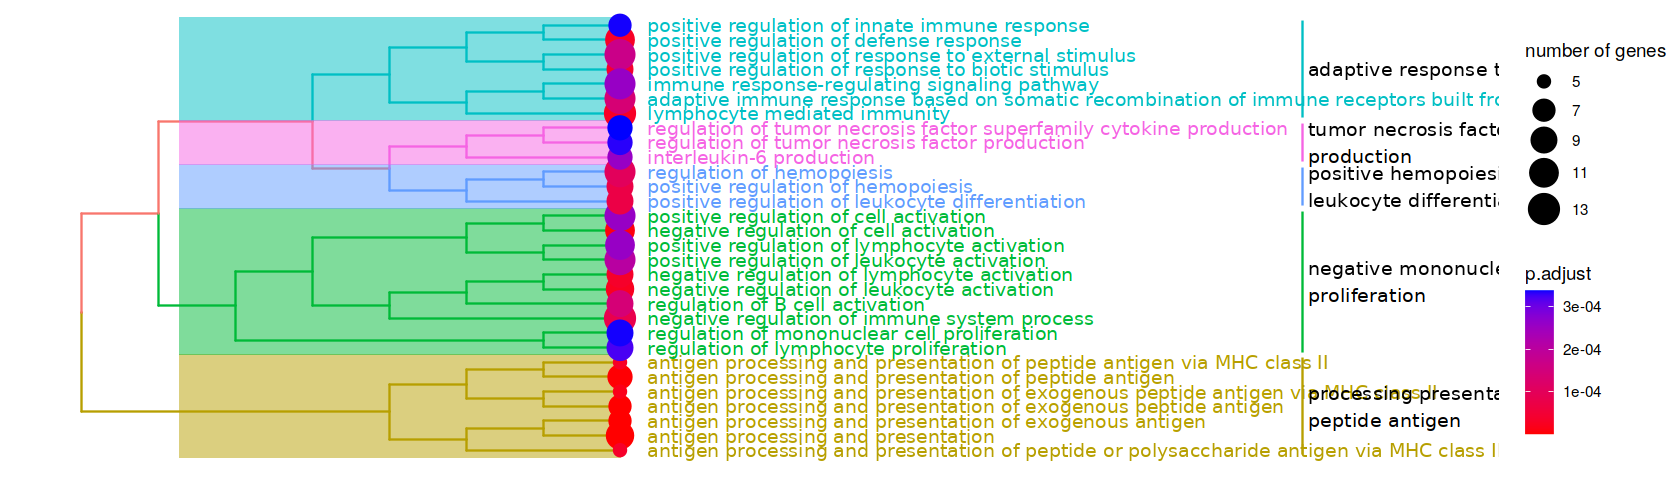

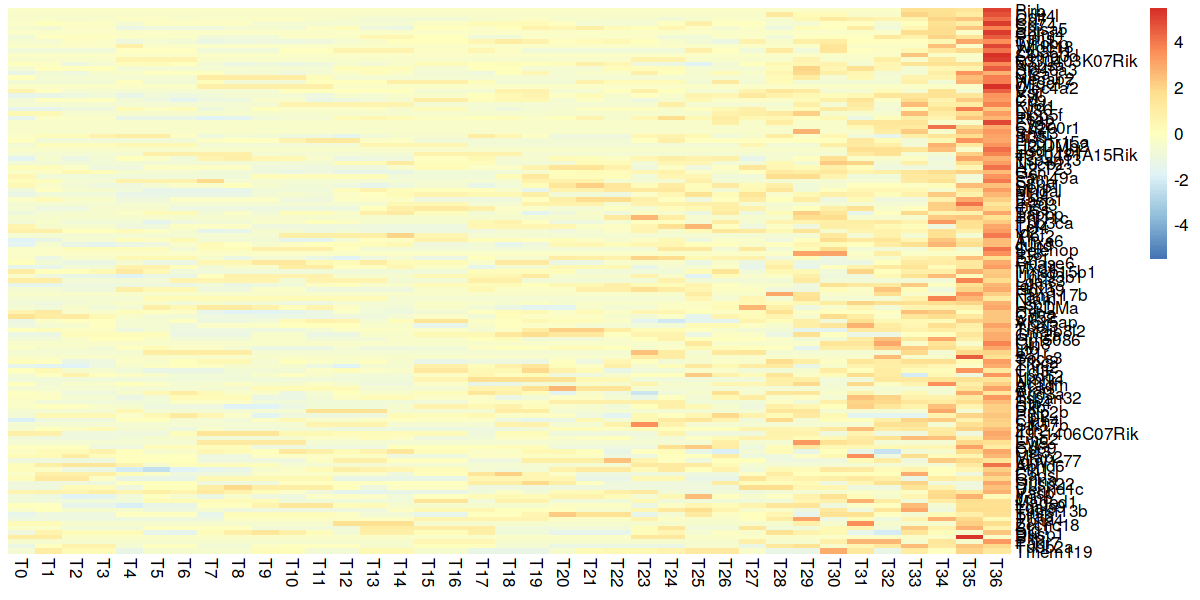

In [12]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C2

[1] "Genes:"
Aurkb Cycs Gfi1b Pclaf Cdca8 Mpo H2afx Anp32b Pcna Srm Syce2 Asf1b Rrm2 Cdk1 Spc24 Mcm5 Tmem121 Ldha Tubb5 Ncl Mif Ranbp1 Dek Tuba1b Fabp5 Shcbp1 Ccna2 Cebpb Smc2 Sell Myc Mcm7 Calr Perp Srebf2 Dut Fam189b Nasp Hist1h1b Dlk1 Cdv3 Stmn1 Hmga2 Lig1 Usp37 Oaf Cks2 Pbk Ap3s1 Kifc1 Ly6d Clspn Mgst2 Nucks1 Tyms Ccnf Calm2 Gm47283 Fbxo5 Hbb-bt Gmnn Ran Ccne2 Zbtb16 Kif2c Csf2ra Tmpo Hells P2rx4 Smc4 Reep4 Kif22 Pim1 Klf2 Cd24a Hmgb2 Kpna2 Comt Hmgb3 Cnn3 Sqle Fyb Prc1 Tubb4b Nde1 Zbtb20 Top2a Uhrf1 Selplg Acp5 Tuba8 Anxa2 Platr17 Tpx2 Ccnb1 Cdca7 Mtss1 Rpa2 Hist1h4i Dhfr Auts2 Hes6 Gpr132 Rexo2 Mcm3 Tuba4a H2-Ab1 Tk1 Tmed3 Hbb-bs Tspo Atad2 Hspa5 Igfbp4 Spaca9 Crip1 E2f1 H2-K1 Prtn3 Cd63 Mta3 Egr1 Dusp2 Eps15 Mis18bp1 Myl10 Sox4 Lat Lyz2 1500009L16Rik Ccnd3 Jpt1 Rrm1 Tmem176a Cd6 Rbpms Atp1b3 Cpa3 Racgap1NULL
[1] "TFs:"
Gfi1b Cebpb Myc Srebf2 Hmga2 Zbtb16 Klf2 Hmgb2 Kpna2 Hmgb3 Zbtb20 Hes6 Mcm3 E2f1 Mta3 Egr1 Mis18bp1 Sox4NULL


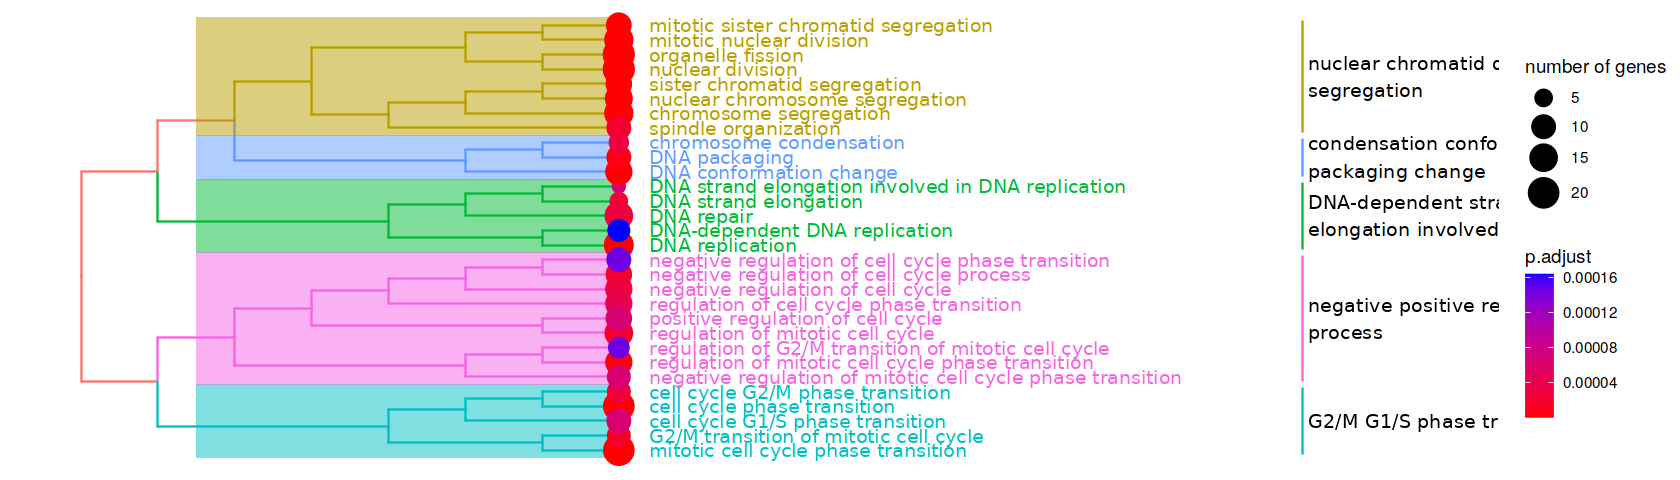

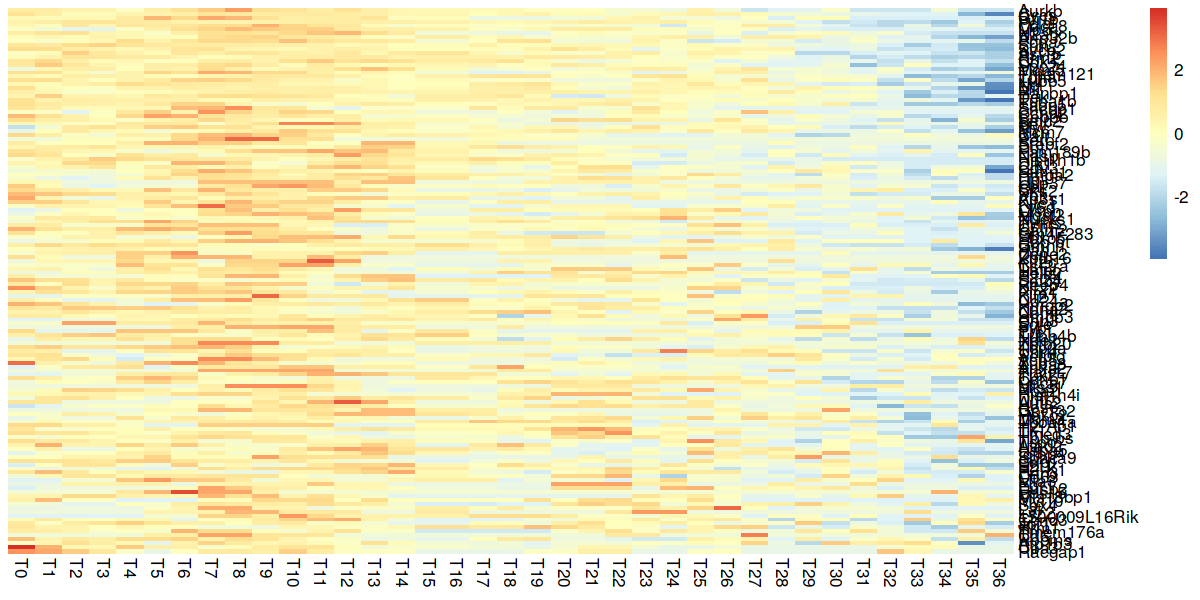

In [13]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C3

[1] "Genes:"
Emb Ccnd2 Abhd17b Ncapd2 Ift57 Ctr9 Slc8b1 Samsn1 Tmem158 S100a6 Ung Pkib Tmem108 Manf Slco4a1 Tuba1c Mid1ip1 Cnn2 Smad7 Cd28 Zfp467 Capn3 Hmgn2 Gadd45b Runx2os1 Cks1b Ctsz Egfl7 Ccnd1 Blvrb Tfrc Gstt2 Ass1 Epsti1 Mcm2 Sstr2 Slbp Rab33b Nek6 Hmgn3 Serpinb1a Morc1 Xlr3b B930036N10Rik Gpr171 Mt1 Rgs1 Spi1 Ifitm1 Birc5 Il12a Glipr1 Cd34 Nfil3 Plek Socs1 Slc37a2 Dnajb9 Xrcc6 Camk2a H2afy Cd96 Gnb4 Ier2 Pnck Gem Ccne1 Cox6a2 Paip1 Il7r Ebf1 Gimap6 Ehbp1l1 Prdx5 Trim55 Incenp Lpcat2 Dkkl1 Apoc1 Hba-a2 H2afz Pola2 Lmnb1 Dok2 Rgcc Fgr Usp18 Gimap9 Tcp11l2 Tcf19 Pou2f2 Sept11 Cd27 Wdcp Grap 1500011B03Rik Ifitm3 Clic4NULL
[1] "TFs:"
Ctr9 Smad7 Zfp467 Ccnd1 Hmgn3 Spi1 Nfil3 Plek Xrcc6 Ebf1 Tcf19 Pou2f2NULL


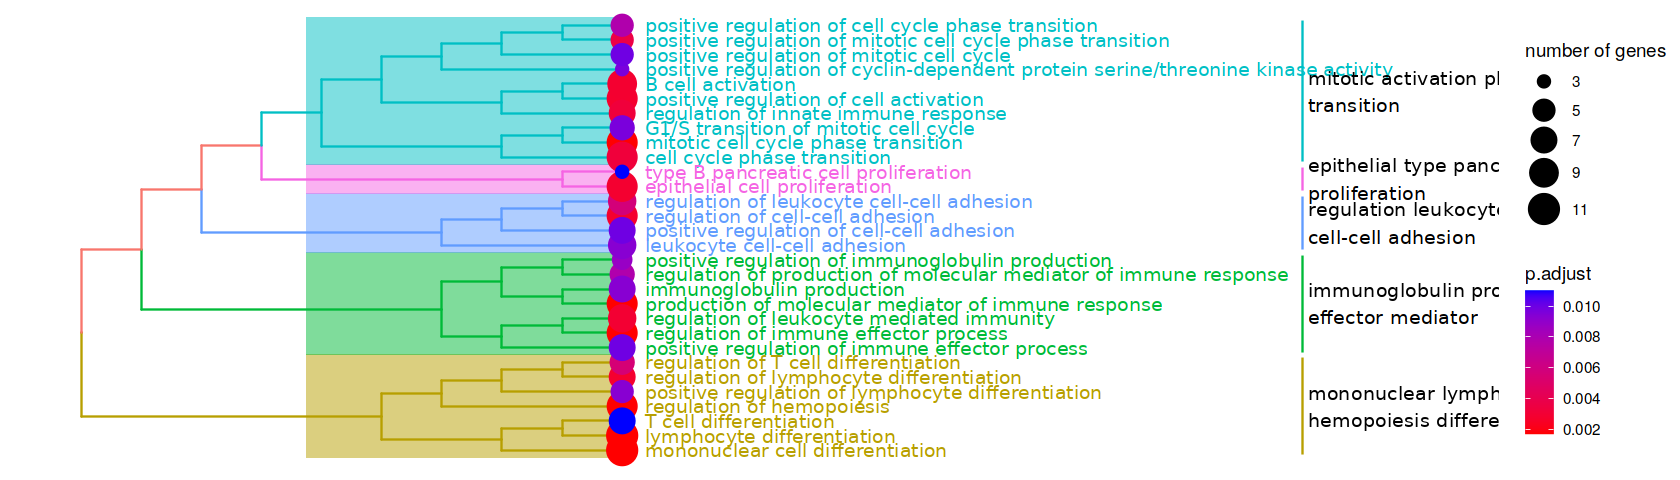

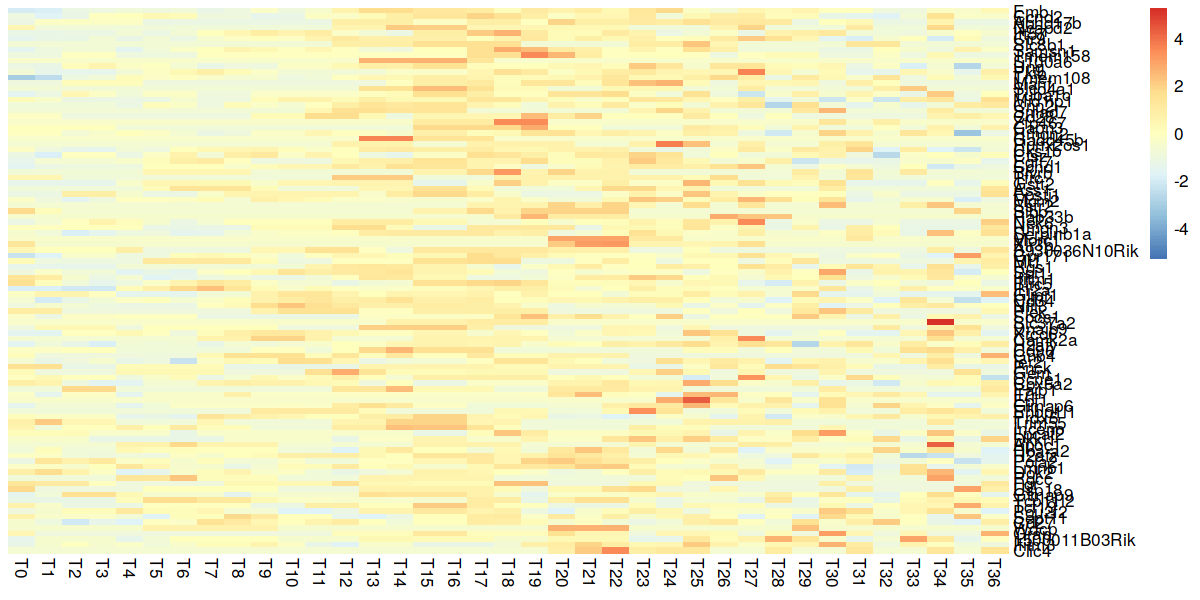

In [14]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Foxf1 Ctnnd2 Pacsin1 Gm19331 Marcks Ifnar1 Rab19 9230105E05Rik Pkp3 Maf Cavin2 Ogt Ccnb2 Hist3h2ba Clec2i Rgs2 Hist1h2bc Tcta Hic1 Ier3 Isg15 Sema4b 2610035D17Rik Rhoh Fcgr3 Tsc22d1 Rasgrp4 Agpat3 Cd81 Tmem51 Lpar6 Arid5b Cdkn1c H2afv Ier5 I830077J02Rik Eva1b Sp100 Pbxip1 Lppos Itm2c Ifi27 Car2 Setd4 Hoxa7 Capg Lockd Cfp Btg2 Hist1h2ac Hlx Lax1 Kdm5b Lgmn Arl6ip1 Jup Notch1 Irf7 Ebi3 Jchain Pdcd1 Blcap Prr13 Ccr7 Lmo4 Pld3 Rgs10 Ccl4 Cenpa Sh2d3c Ctso Gpcpd1 Herpud1 Trp53i11 Plin3 Lck Cd72 Lst1 Ccr9 1700097N02Rik S100a4 Lztfl1 Plaur Tnfrsf13c Anxa5 H2-Oa Grifin Tmeff2 Grhpr Scpep1 Ifi27l2a Paqr5 Gfod2 Vim Tbxa2r Bdh1 Ddit4 Hvcn1 Dnajb14 Ptpre 9130015A21Rik Isg20 Batf3 Fads3 S100a11 Gata3 H1f0 Ctsb Smim5 Grn Gimap4 Smox Slc35d3 Xlr4a Ak8 FosNULL
[1] "TFs:"
Foxf1 Maf Hic1 Tsc22d1 Arid5b Sp100 Hoxa7 Btg2 Hlx Notch1 Irf7 Lmo4 Cenpa Batf3 Gata3 FosNULL


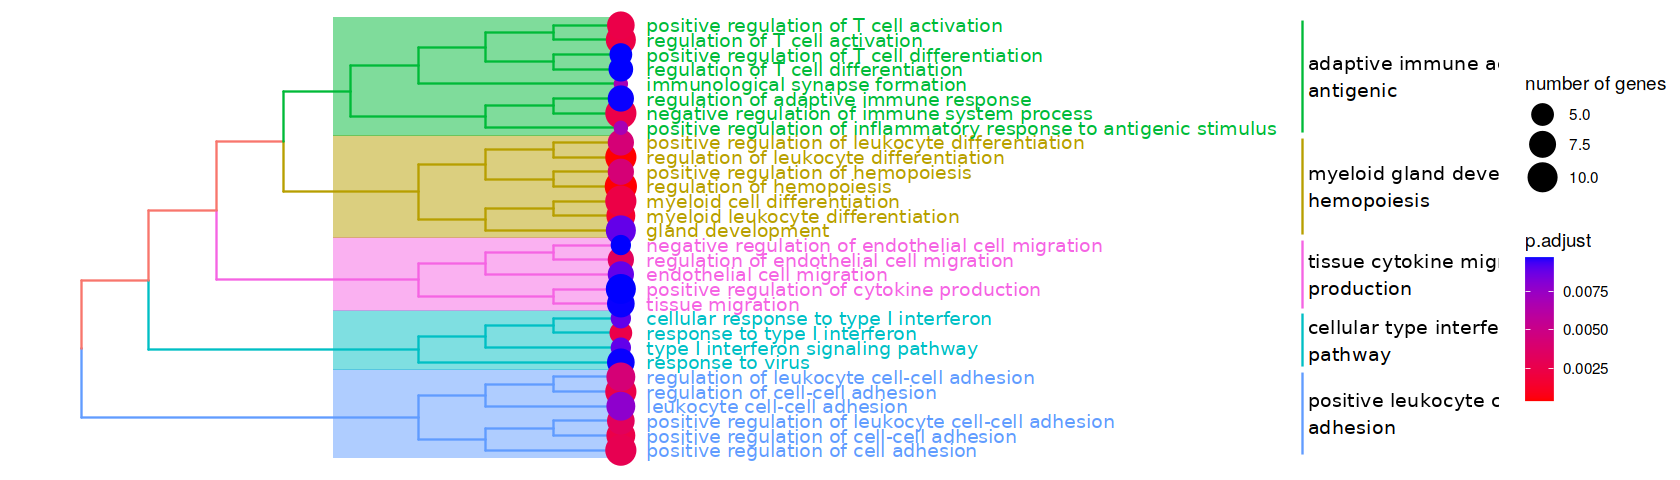

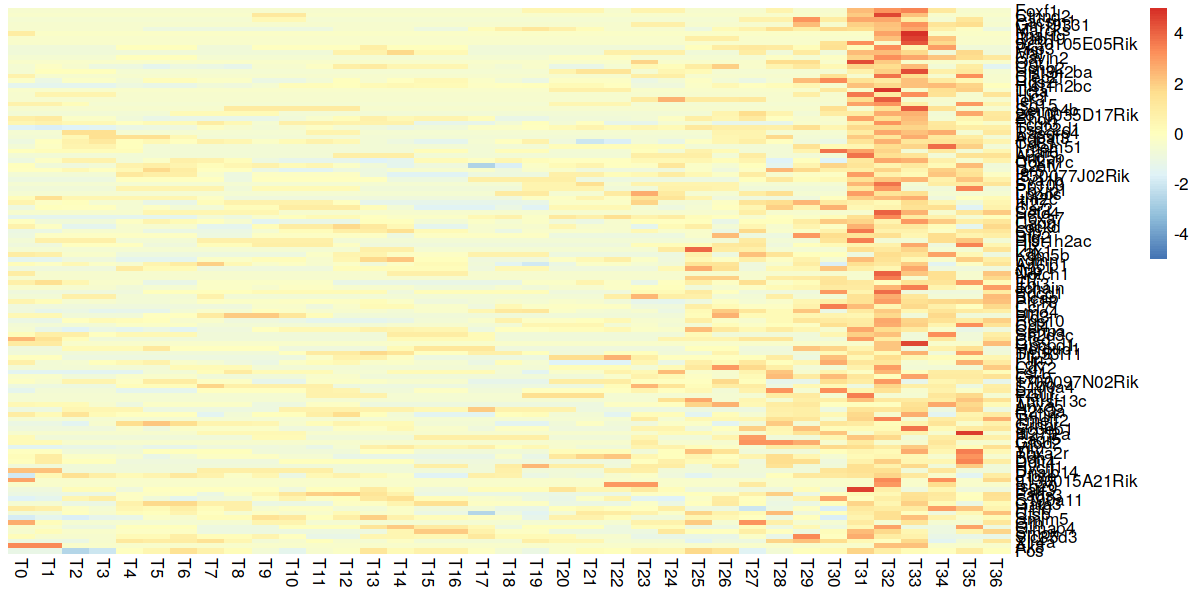

In [15]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Gm4208 Hp Dennd5b Sapcd2 Hes1 2610528A11Rik Ncf4 Thy1 Tcrg-C1 Slc43a2 Ablim1 Pglyrp1 Ms4a4b Naga Ube2s Noa1 Hmmr Bst2 Sgo1 1110008P14Rik Ldhb Asah1 Sat1 Tox Fxyd7 Pimreg Zfp992 Tpm2 Rpgrip1 Trbc1 Gzma Fcer1g 2310001H17Rik Lgals3bp Cd3g Kif20b Khk Nkg7 Dtl Dlgap5 Slfn5 H19 Agl Bcl2 Cdca3 Kif20a Il6ra Gm26917 Lta Nudt18 Ly6e Mki67 Galnt12 Tnni1 H2-DMb1 Ube2c Spc25 Dbt Hist1h1c Bambi Fdps Aurka Gyg Klf13 Fgd2 Xlr4b Mcpt8 Ctsc Msmo1 Unc13d Lgals1 Pycard N4bp2l1 Trim12a Cldnd1 Ifitm2 Pdia5 Tacc3 Pdlim2 Sla2 Bfsp2 Ttf1 Gm15518 Tox2 Gstm5 Cers6 Fbxo6 Nfkb1 Gm49169 H2-M3 Selenos Cdkn3 Gngt2 Bub3 Nfkbia Irf8 Dlgap4 Tipin Smpdl3a Izumo4 Ctsw Ptprc Tmem50b Hk2 H2-D1 Hsp90b1 Cdyl2 Rassf4 P2ry14 Plxnc1 Ctsl Anxa1 Carhsp1 Ckap2l Hist1h2ae Gimap5 Mcm6 Cdk6NULL
[1] "TFs:"
Hes1 Tox Zfp992 Klf13 Sla2 Ttf1 Tox2 Nfkb1 Bub3 Nfkbia Irf8 Carhsp1 Mcm6NULL


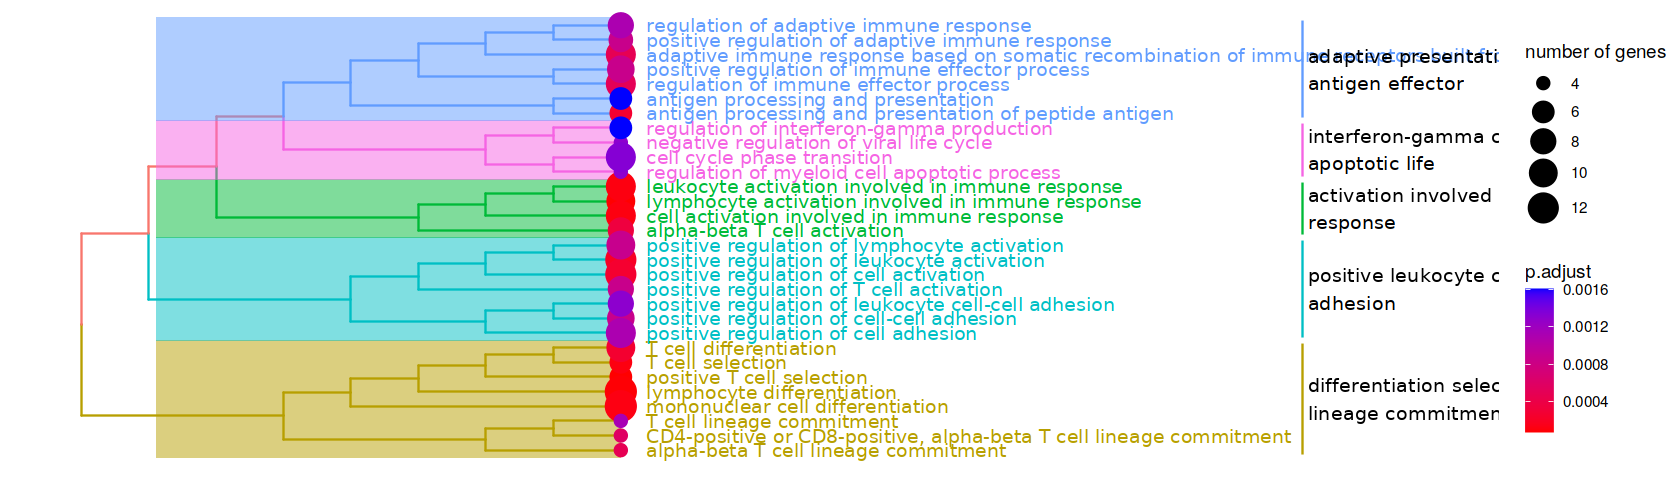

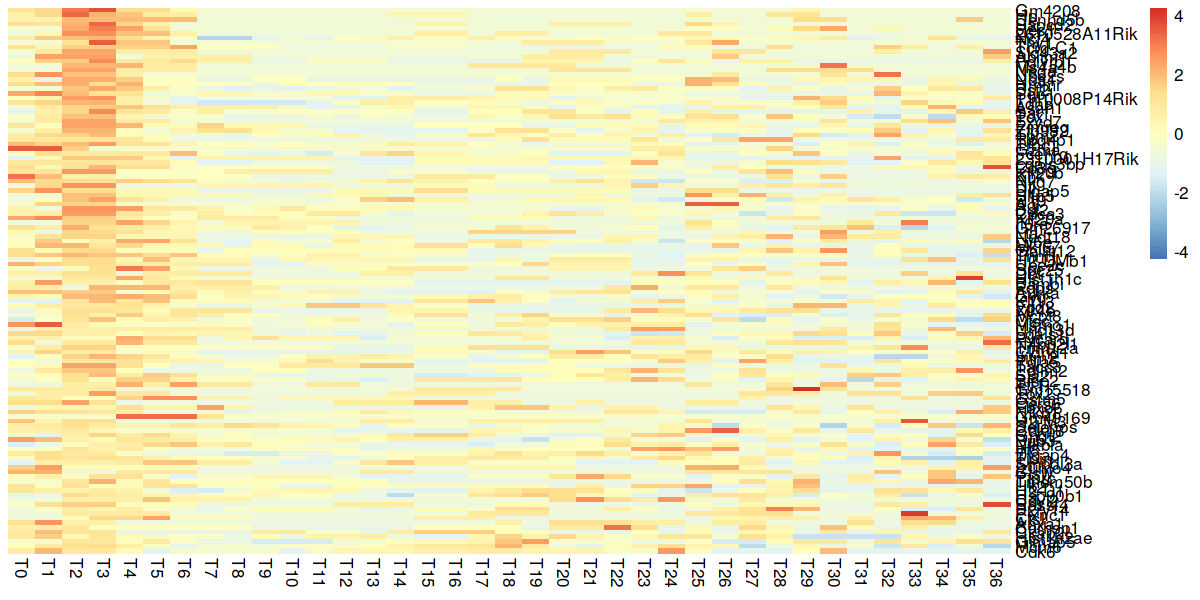

In [16]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)

